# Brain Tumor Classification: Setup & EDA
### Eric Chase

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Brain-Tumor-Classification:-Setup-&amp;-EDA" data-toc-modified-id="Brain-Tumor-Classification:-Setup-&amp;-EDA-1">Brain Tumor Classification: Setup &amp; EDA</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Eric-Chase" data-toc-modified-id="Eric-Chase-1.0.1">Eric Chase</a></span></li></ul></li></ul></li><li><span><a href="#import" data-toc-modified-id="import-2">import</a></span></li><li><span><a href="#paths" data-toc-modified-id="paths-3">paths</a></span></li><li><span><a href="#reproducibility-&amp;-maintenance" data-toc-modified-id="reproducibility-&amp;-maintenance-4">reproducibility &amp; maintenance</a></span></li><li><span><a href="#kaggle-data-download" data-toc-modified-id="kaggle-data-download-5">kaggle data download</a></span></li><li><span><a href="#remove-duplicates" data-toc-modified-id="remove-duplicates-6">remove duplicates</a></span></li><li><span><a href="#eda" data-toc-modified-id="eda-7">eda</a></span></li><li><span><a href="#class-sizes" data-toc-modified-id="class-sizes-8">class sizes</a></span></li><li><span><a href="#preprocess-images-(&quot;normalize&quot;)" data-toc-modified-id="preprocess-images-(&quot;normalize&quot;)-9">preprocess images ("normalize")</a></span><ul class="toc-item"><li><span><a href="#a-single,-detailed-preprocessing-walkthrough..." data-toc-modified-id="a-single,-detailed-preprocessing-walkthrough...-9.1">a single, detailed preprocessing walkthrough...</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#thresholding-for-segmentation" data-toc-modified-id="thresholding-for-segmentation-9.1.0.1">thresholding for segmentation</a></span></li><li><span><a href="#finding-the-outer-contour-curve-points" data-toc-modified-id="finding-the-outer-contour-curve-points-9.1.0.2">finding the outer contour curve points</a></span></li><li><span><a href="#crop-the-image-to-the-extreme-values" data-toc-modified-id="crop-the-image-to-the-extreme-values-9.1.0.3">crop the image to the extreme values</a></span></li><li><span><a href="#resize-images" data-toc-modified-id="resize-images-9.1.0.4">resize images</a></span></li></ul></li></ul></li><li><span><a href="#rename-image-files-to-contain-class-number-for-safe-keeping" data-toc-modified-id="rename-image-files-to-contain-class-number-for-safe-keeping-9.2">rename image files to contain class number for safe keeping</a></span></li><li><span><a href="#preprocessing-functions" data-toc-modified-id="preprocessing-functions-9.3">preprocessing functions</a></span></li><li><span><a href="#run-preprocessing-&amp;-train/val-split" data-toc-modified-id="run-preprocessing-&amp;-train/val-split-9.4">run preprocessing &amp; train/val split</a></span></li><li><span><a href="#examine-the-preprocessed-directories" data-toc-modified-id="examine-the-preprocessed-directories-9.5">examine the preprocessed directories</a></span></li></ul></li><li><span><a href="#data-generators" data-toc-modified-id="data-generators-10">data generators</a></span><ul class="toc-item"><li><span><a href="#viz-generated-images" data-toc-modified-id="viz-generated-images-10.1">viz generated images</a></span></li></ul></li><li><span><a href="#all-set-for-modeling!" data-toc-modified-id="all-set-for-modeling!-11">all set for modeling!</a></span></li></ul></div>

# import

In [1]:
# tensorflow tools #
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import (Dense, Input, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D,
                                     Conv2D, Flatten, Dropout, BatchNormalization) 
from tensorflow.keras.activations import sigmoid, softmax, relu
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# ml viz
from tensorboard.plugins.hparams import api as hp 
%load_ext tensorboard
import pydot 
import graphviz 
# sklearn tools #
import sklearn 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD
# image tools # 
from tensorflow.keras.preprocessing import image 
import cv2
import imutils
# data handling tools #
import numpy as np
import pandas as pd 
# plotting tools #
import matplotlib.pyplot as plt 
import seaborn as sns 
# general tools #
import datetime
from collections import Counter
import os 
pjoin = os.path.join
import shutil
import gc
import pickle 
import itertools
import re 
import string 
import kaggle

# paths

In [3]:
download_path = './download'
raw_train_dir = os.path.join(download_path, 'Training')
raw_test_dir = os.path.join(download_path, 'Testing')
train_path, val_path, test_path = './train', './val', './test'
for path in [download_path, train_path, val_path, test_path]:
    if not os.path.exists(path):
        os.mkdir(path)

# reproducibility & maintenance

In [4]:
keras.backend.clear_session()
tf.random.set_seed(38)
np.random.seed(38)
_= gc.collect() 

# kaggle data download

In [5]:
download = False 

if download:
    kaggle.api.dataset_list(search='brain tumor mri')
    kaggle.api.dataset_download_files(dataset='sartajbhuvaji/brain-tumor-classification-mri',
                                      path=download_path, unzip=True)

# remove duplicates
I had a hard realization at the end of this project.  This data was downloaded from Kaggle and it's usablility score was a 5/10.  As it turns out, there are many duplicates scattered throughout, and the test set has many mislabeled images resulting in a drastic disparity between the validation scores and the test scores.  For this reason, as I don't have access to a subject matter expert, the test scores are considered irrelevant and discounted.  
<br>
Here, because the images contain 3 million pixels, checking for duplicates on this level is out of reach.  So, I read them image into tensors, flattened them, hashed them, and compared the hashes to identify duplicates. 

In [6]:
# REMOVE DUPLICATES #
def remove_duplicates(main_dir):
    print(main_dir)
    for cl in os.listdir(main_dir):
        if not cl.startswith('.'):
            print(cl)
            full = pd.DataFrame(columns=['hash'])
            fname_ls = os.listdir(pjoin(main_dir,  cl))

            for image_fname in fname_ls:
                if image_fname.endswith('jpg'):
                    # processing
                    img = cv2.imread(pjoin(main_dir,  cl, image_fname))
                    flattened = img.reshape(1,-1).squeeze()
                    full.loc[image_fname,'hash'] = hash(flattened.tobytes())
            # dedupe directory
            dups = full[full.duplicated()]
            print('DUPLICATES: ', dups.shape[0])
            for fname in dups.index:
                try:
                    os.remove(pjoin(main_dir, cl, fname))
                except Exception as e:
                    pass 


In [7]:
dedupe = False 

if dedupe:
    # remove duplicates #
    for main_dir in os.listdir('./download'):
        if not main_dir.startswith('.'):
            remove_duplicates(pjoin('./download', main_dir))
    

# eda

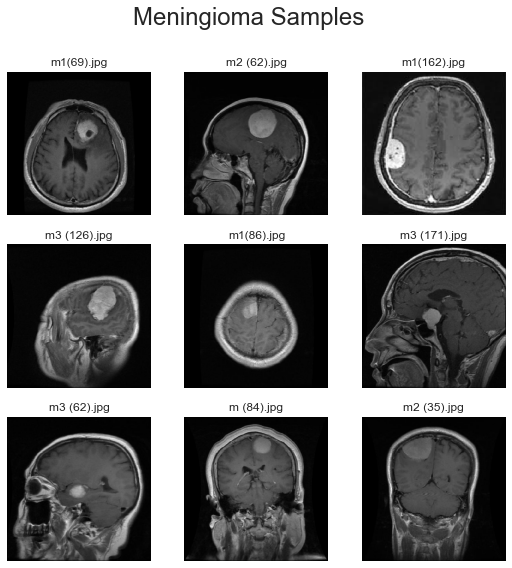

In [20]:
sns.set(style='white')
fig,ax = plt.subplots(3,3, figsize=(9,9))
i,j = 0,0
for fname in os.listdir('./download/Training/meningioma_tumor/')[:9]:
    img = image.load_img('./download/Training/meningioma_tumor/' + fname, 
                         target_size=(244,244), 
                         color_mode='grayscale')
    ax[i,j].imshow(img, cmap='gist_gray')
    ax[i,j].set_axis_off() 
    ax[i,j].set_title(fname) 
    i += 1
    if i == 3: 
        j += 1
        i = 0
        
plt.suptitle('Meningioma Samples', fontsize=24)
plt.savefig('./images/meningioma_samples.png', dpi=600, bbox_inches='tight')

# class sizes

In [21]:
min_cl_size = 10**10
for dir in os.listdir(raw_train_dir):
    if os.path.isdir(os.path.join(raw_train_dir, dir)):
        n = len(os.listdir(os.path.join(raw_train_dir, dir)))
        if n < min_cl_size:
            min_cl_size = n 
        print(f'{dir}:'.rjust(20) + f'{n}'.rjust(5))

print(f'The minimum class size is {min_cl_size}'.rjust(5))

           no_tumor:  395
   meningioma_tumor:  822
       glioma_tumor:  826
    pituitary_tumor:  827
The minimum class size is 395


In [22]:
val_size = int(min_cl_size * .2)
print(f'The validation size @ 20% is {val_size}'.rjust(5))

The validation size @ 20% is 79


# preprocess images ("normalize")
1. center and crop images
2. resize images  
<br>
*Building upon the fantastic walkthrough provided by PyImageSearch found at* https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/

## a single, detailed preprocessing walkthrough...

#### thresholding for segmentation
performs thresholding, allowing us to segment the hand region from the rest of the image.

In [29]:
# load the image
image_fname = os.listdir(pjoin(raw_train_dir, 'meningioma_tumor'))[141]
# img = cv2.imread(pjoin(raw_train_dir, 'meningioma_tumor', 'm1(64).jpg'))
img = cv2.imread(pjoin(raw_train_dir, 'meningioma_tumor', image_fname))
# convert image to gray scale (compress dim3)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# slightly blur image
blurred = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=0)
# threshold the image
thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)[1]
# erode then dilation to remove any small regions of noise
dilated = cv2.dilate(thresh, None, iterations=9)
eroded = cv2.erode(dilated, None, iterations=3)
# find contours in thresholded image
contours = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
# grab the largest contour
c = max(contours, key=cv2.contourArea)

In [31]:
c.shape 

(463, 1, 2)

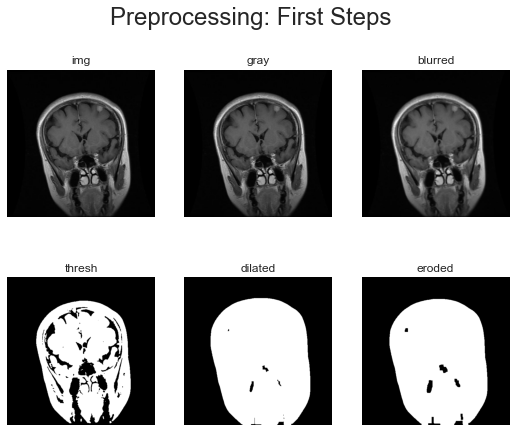

In [38]:
sns.set(style='white')
fig,ax = plt.subplots(2,3, figsize=(9,7))
titles = 'img gray blurred thresh dilated eroded'.split()
i,j,k = 0,0,0
for im in [img, gray, blurred, thresh, dilated, eroded]:
    ax[i,j].imshow(im, cmap='gist_gray')
    ax[i,j].set_title(titles[k])
    ax[i,j].set_axis_off()
    j += 1
    k += 1
    if j == 3: 
        i += 1
        j = 0
        
plt.suptitle('Preprocessing: First Steps', fontsize=24)
plt.savefig('./images/preprocessing_first_steps.png', dpi=600, bbox_inches='tight')

#### finding the outer contour curve points

In [33]:
# determine the most extreme points along the contour for plotting
left = tuple(c[c[:, :, 0].argmin()][0])
right = tuple(c[c[:, :, 0].argmax()][0])
bottom = tuple(c[c[:, :, 1].argmin()][0])
top = tuple(c[c[:, :, 1].argmax()][0])

left, right, bottom, top

((95, 207), (433, 394), (244, 76), (206, 511))

In [34]:
## build the bounding box containing axis extreme values for cropping ##
# min of x axis
xmin = c[c[:, :, 0].argmin()].squeeze()[0]
# max of x axis
xmax = c[c[:, :, 0].argmax()].squeeze()[0]
# min of y axis
ymin = c[c[:, :, 1].argmin()].squeeze()[1]
# max of x axis
ymax = c[c[:, :, 1].argmax()].squeeze()[1]
bbox = dict(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
bbox 

{'xmin': 95, 'xmax': 433, 'ymin': 76, 'ymax': 511}

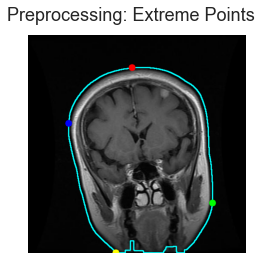

In [43]:
# draw the outline of the object on the image
img_contours = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 2)
# draw each of the extreme points on the image
cv2.circle(img_contours, left, 8, (0, 0, 255), -1)
cv2.circle(img_contours, right, 8, (0, 255, 0), -1)
cv2.circle(img_contours, bottom, 8, (255, 0, 0), -1)
cv2.circle(img_contours, top, 8, (255, 255, 0), -1)
# show the output img
plt.imshow(img_contours)

plt.axis('off')
plt.suptitle('Preprocessing: Extreme Points', fontsize=18)
plt.savefig('./images/preprocessing_extreme_points.png', dpi=600, bbox_inches='tight')

In [36]:
img.shape 

(512, 512, 3)

#### crop the image to the extreme values

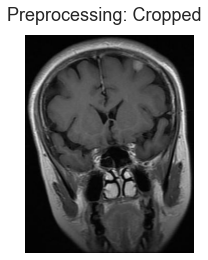

In [44]:
# crop the image to axis extreme values #
cropped = img[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax'], :]
plt.imshow(cropped)
plt.axis('off')

plt.suptitle('Preprocessing: Cropped', fontsize=18)
plt.savefig('./images/preprocessing_cropped.png', dpi=600, bbox_inches='tight')

#### resize images

In [45]:
cropped.shape 

(435, 338, 3)

In [46]:
# resize the image to 224x224
cv2.resize(cropped, (224,224)).shape 

(224, 224, 3)

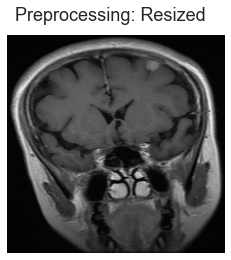

In [47]:
resized = cv2.resize(cropped, (224,224))
plt.imshow(resized)
plt.axis('off')

plt.gca().set_axis_off() 
plt.suptitle('Preprocessing: Resized', fontsize=18)
plt.savefig('./images/preprocessing_resized.png', dpi=600, bbox_inches='tight')

## rename image files to contain class number for safe keeping

In [49]:
rename_files = False
classes = {'no_tumor':0, 'meningioma_tumor':1, 'glioma_tumor':2, 'pituitary_tumor':3}

if rename_files:
    # training images #
    for dir in os.listdir(raw_train_dir):
        if os.path.isdir(os.path.join(raw_train_dir, dir)):
            class_num = classes[dir]
            dir_path = os.path.join(raw_train_dir, dir)
            i = 0
            for f in os.listdir(dir_path):
                if f.endswith('jpg'):
                    shutil.move(os.path.join(dir_path, f), os.path.join(dir_path, f'{class_num}-{i}.jpg'))
                    i += 1

    # testing images #
    for dir in os.listdir(raw_test_dir):
        if os.path.isdir(os.path.join(raw_test_dir, dir)):
            class_num = classes[dir]
            dir_path = os.path.join(raw_test_dir, dir)
            i = 0
            for f in os.listdir(dir_path):
                if f.endswith('jpg'):
                    shutil.move(os.path.join(dir_path, f), os.path.join(dir_path, f'{class_num}-{i}.jpg'))
                    i += 1

## preprocessing functions 

In [50]:
def get_bbox(img):
    ''' Given an image tensor, returns the bounding box for cropping. '''
    # convert image to gray scale (compress dim3)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # slightly blur image
    blurred = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=0)
    # threshold the image
    thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)[1]
    # erode then dilation to remove any small regions of noise
    dilated = cv2.dilate(thresh, None, iterations=7)
    eroded = cv2.erode(dilated, None, iterations=5)
    # find contours in thresholded image
    contours = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    # grab the largest contour
    c = max(contours, key=cv2.contourArea)
    
    # determine the most extreme points along the contour #
    # Note: c = n_contours x n_channels x 2 (the image dim count = 2 = [x,y])
    # min of x axis
    xmin = c[c[:,:,0].argmin()].squeeze()[0]
    # max of x axis
    xmax = c[c[:,:,0].argmax()].squeeze()[0]
    # min of y axis
    ymin = c[c[:,:,1].argmin()].squeeze()[1]
    # max of x axis
    ymax = c[c[:,:,1].argmax()].squeeze()[1]
    bbox = dict(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    
    return bbox

In [51]:
def crop_image(img, bbox):
    ''' Given an image tensor and a bounding box dict, returns the cropped image. '''
    # crop the image to the bbox limits
    cropped = img[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax'], :]
    return cropped

In [52]:
def resize_image(img, target_size):
    ''' Given an image and a target size tuple, returns the resized image tensor. '''
    resized = cv2.resize(img, target_size)
    return resized 

In [53]:
def save_image(img, image_fname, dest_dir):
    ''' Saves the image to the given director with the given filename. '''
    cv2.imwrite(os.path.join(dest_dir, image_fname), img)

In [54]:
def preprocess_images(src_dir, dest_dir, target_size, start_idx=None, end_idx=None):
    ''' For each image file name in the source directory starting and ending on 
        the given indices, the images are cropped, resized, and saved to the 
        destination directory.  If no end index is given, processes the whole
        directory (think test directory). '''
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    fname_ls = os.listdir(src_dir)
    if not end_idx:
        start_idx, end_idx = 0, len(fname_ls)
        
    for i in range(start_idx, end_idx):
        image_fname = fname_ls[i]
        if image_fname.endswith('jpg'):
            # processing
            img = cv2.imread(os.path.join(src_dir, image_fname))
            bbox = get_bbox(img)
            cropped = crop_image(img, bbox)
            resized = resize_image(cropped, target_size)
            save_image(resized, image_fname, dest_dir)

## run preprocessing & train/val split

In [55]:
target_size = (224,224)
preprocess = False  

if preprocess:
    # normalize images #
    for cl in os.listdir(raw_train_dir):
        if not cl.startswith('.'):
            # train #
            preprocess_images(os.path.join(raw_train_dir, cl), 
                              os.path.join(train_path, cl), 
                              target_size, 
                              val_size,
                              min_cl_size)
            # val #
            preprocess_images(os.path.join(raw_train_dir, cl), 
                              os.path.join(val_path, cl), 
                              target_size, 
                              0,
                              val_size)
            # test #
            preprocess_images(os.path.join(raw_test_dir, cl), 
                              os.path.join(test_path, cl), 
                              target_size)

## examine the preprocessed directories

In [56]:
for maindir in [train_path, val_path, test_path]:
    for subdir in os.listdir(maindir):
        if os.path.isdir(os.path.join(maindir, subdir)):
            n = len(os.listdir(os.path.join(maindir, subdir)))
            print(f'{maindir}/{subdir}:'.rjust(30) + f'{n}'.rjust(5))

             ./train/no_tumor:  262
     ./train/meningioma_tumor:  262
         ./train/glioma_tumor:  262
      ./train/pituitary_tumor:  262
               ./val/no_tumor:   65
       ./val/meningioma_tumor:   65
           ./val/glioma_tumor:   65
        ./val/pituitary_tumor:   65
              ./test/no_tumor:   81
      ./test/meningioma_tumor:  113
          ./test/glioma_tumor:   84
       ./test/pituitary_tumor:   36


# data generators

In [62]:
# train generator instantiation
train_im_datagen = image.ImageDataGenerator(rescale=1./255, 
                                     rotation_range=.15, 
                                     width_shift_range=0, 
                                     height_shift_range=0, 
                                     brightness_range=(.1, .9),
                                     shear_range=.15,
                                     zoom_range=0,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     data_format='channels_last',
                                     validation_split=0)
# test generator instantiation
test_im_datagen = image.ImageDataGenerator(rescale=1./255)

In [67]:
def get_data_gens(batch_size):
    ''' Given the batch size, returns a tuple of generators from the 
        designated train, val, and test paths:  (traingen, valgen, testgen). '''
    # train data flow inititalized #
    traingen = train_im_datagen.flow_from_directory(train_path, 
                                                    target_size=target_size, 
                                                    color_mode='rgb',
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    shuffle=True,
                                                    seed=38)
    # val data flow inititalized #
    valgen = test_im_datagen.flow_from_directory(val_path, 
                                                 target_size=target_size, 
                                                 color_mode='rgb',
                                                 class_mode='categorical', 
                                                 batch_size=batch_size, 
                                                 shuffle=False,
                                                 seed=38)
    # test data flow inititalized #
    testgen = test_im_datagen.flow_from_directory(test_path, 
                                                  target_size=target_size, 
                                                  color_mode='rgb',
                                                  class_mode='categorical', 
                                                  batch_size=batch_size, 
                                                  shuffle=False,
                                                  seed=38)
    
    return traingen, valgen, testgen


In [68]:
traingen, valgen, testgen = get_data_gens(32)

Found 1048 images belonging to 4 classes.
Found 260 images belonging to 4 classes.
Found 314 images belonging to 4 classes.


In [69]:
valgen.batch_size, valgen.n

(32, 260)

## viz generated images

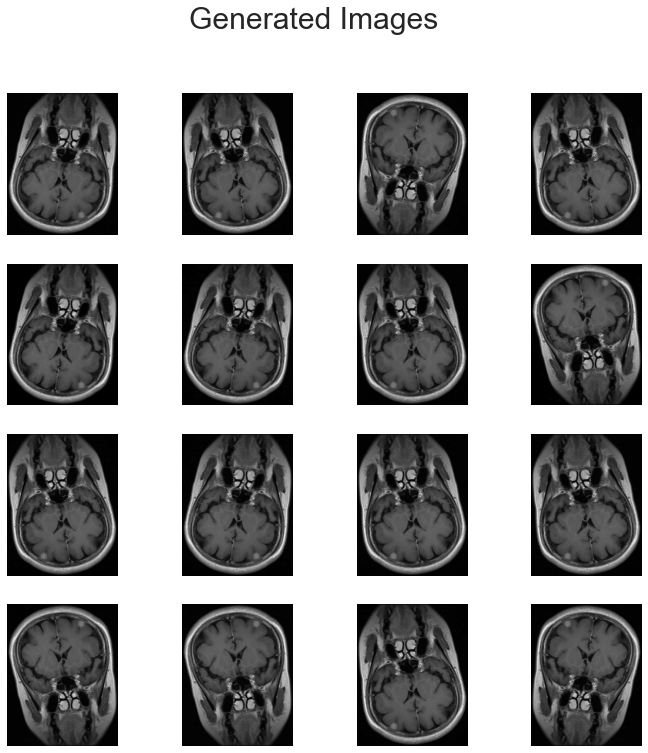

In [72]:
fig,ax = plt.subplots(4, 4, figsize=(12,12))

x = cropped[np.newaxis,:,:,:]
i,j,k = 0,0,0
for batch in train_im_datagen.flow(x, batch_size=1):
    ax[i,j].imshow(image.array_to_img(batch[0]))
    ax[i,j].set_axis_off()
    i += 1
    k += 1
    if i == 4:
        i = 0
        j += 1
    if k % 16 == 0:
        break 

plt.suptitle('Generated Images', fontsize=30)
plt.savefig('./images/preprocessing_generated_images.png', dpi=600, bbox_inches='tight')

# all set for modeling!